c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torch\functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


Loaded sample with track_id: ['19316957-7db5-435d-b0e5-3c99332ee329']


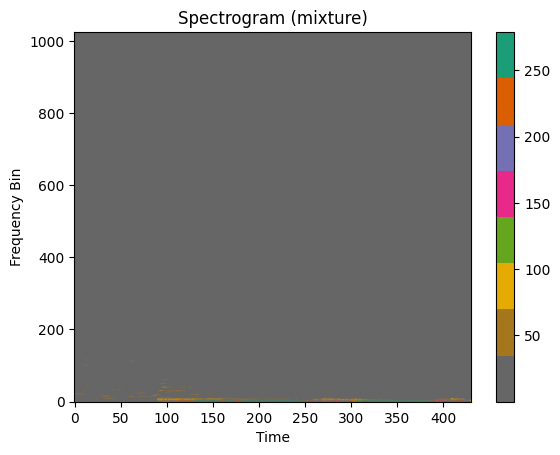

In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from process_musdb18 import AudioDatasetFolder

# Create dataset instance.
# Note: Adjust audio_dir if the file paths in your CSV are relative to a different base folder.
dataset = AudioDatasetFolder(
    csv_file='output_stems/musdb18_index_20250408_121813.csv',
    audio_dir='.',  # or adjust to your actual base audio directory
    sample_rate=44100,
    duration=5.0  # Load only the first 10 seconds
)

# Create a DataLoader to iterate through the dataset.
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Retrieve a sample
sample = next(iter(loader))
print("Loaded sample with track_id:", sample['track_id'])

# For example, plot the spectrogram for the 'mixture' component.
# Since the computed spectrogram is stereo ([channels, freq, time]),
# we extract the first channel (index 0) to get a 2D array [freq, time].
spec = sample['mixture'][0, 0]  # [batch, channels, freq, time] -> select first sample and first channel

plt.imshow(spec.detach().numpy(), origin='lower', aspect='auto',cmap='Dark2_r')
plt.title("Spectrogram (mixture)")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.colorbar()
plt.show()
